Homework 2
Question #1: I've used Bell et al 2003 Mass to Light ratio calibration curve described in ex03 ipython notebook to find the stellar mass distribution

In [1]:
%matplotlib inline

import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)

# Bayesian machine learning probabilities of morphological classes from Huertas-Company et al. 2011, AA 525, 157
# probaE is probability to be early type (either E or S0); 1-probaE is probability to be spiral
# probaEll = probability to be elliptical; probaS0 = p(S0); probaSab = p(Sa or Sb); probaScd = p(Sc, Sd, or Irr)
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 

670722 galaxies in Meert et al. sample initially


selected 239462  after all cuts...


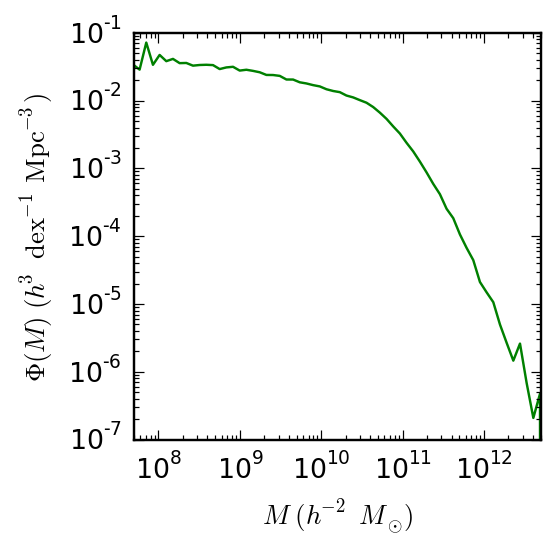

In [2]:
def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))

grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

ilim = ((mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) 
        & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2) & (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0))

sdata = sdata[ilim]; mdata = mdata[ilim]; mdatag = mdatag[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; mnpdatag = mnpdatag[ilim]; grm = grm[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']
pEll = pEll[ilim]; pS0 = pS0[ilim]; pSab = pSab[ilim]; pScd = pScd[ilim]

print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;
Mmodel = phot_r['ModelMag'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
Lmodel = 0.4*(4.67-(Mmodel))
zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

#Converting Lr to stellar mass using colour with the Bell et al calibration
#lMLrzib = -0.840 + 1.654*xur
lMLrzib = (-0.840 + 1.654*grm)
lMLrbell = -.306 + 1.097*grm - 0.1
SMmeert = Lmeert+lMLrbell
phi_Mmeert, Mbins = np.histogram(SMmeert, weights=vmaxim, bins=nbins)
Mbinc = 0.5 * (Mbins[1:] + Mbins[:-1]); dMbins = (Mbins[1:]-Mbins[:-1])

phi_Mbsmeert, ephi_Mbsmeert = compute_lf_bootstrap(SMmeert, vmaxim, Mbins, nbootstrap)

phi_Mbsmeert = phi_Mbsmeert  / dMbins / cosmo.h**3
ephi_Mbsmeert = ephi_Mbsmeert  / dMbins / cosmo.h**3
ephi_Mbsmeert = np.nan_to_num(ephi_Mbsmeert)

Mbinc = np.log10(10.**Mbinc*cosmo.h**2)

#
# plot LF
#
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e12); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Mbinc, phi_Mbsmeert, c='g')

Question #2

In [3]:
from code.setup import data_home_dir

def compute_inverse_Vmax(mags, zs, m_min=None, m_max=None, cosmomodel='WMAP9'):
    """compute inverse Vmax for a given set of galaxy magnitudes and redshifts, given magnitude limits m_min and m_max"""
    #from code.calc_kcor import calc_kcor 
    #ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
    #kcorr = calc_kcor('r', zk, 'g - r', grm)
    from colossus.cosmology import cosmology
    # set cosmology to the best values from 9-year WMAP data
    cosmo = cosmology.setCosmology(cosmomodel)

    # compute luminosity and angular distances
    d_L = cosmo.luminosityDistance(zs)/cosmo.h

    # absolute magnitude in the r-band corrected for extinction
    Mabs = mags - 5.0*np.log10(d_L/1e-5) #- extm + 1.3*zs - kcorr; 

    # the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
    # we need to compute at what distance this galaxy would have limiting magnitude mlim, 
    # then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
    d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mabs))/(1.+zs)
    d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mabs))/(1.+zs)

    vmaxi = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))
    return vmaxi

def read_GAMA(fname):
    import pyfits
    hdulist = pyfits.open(fname)
    return np.asarray(hdulist[1].data)

#data = read_GAMA(data_home_dir()+"GAMA_AEAtSz.fits")
data = read_GAMA(data_home_dir()+"GAMA_DR2_full.fits")

z_min = 0.001
z_max = 0.2
m_min = 10.5
m_max = 19.

mrpetro = data['PETROMAG_R'] - data['EXTINCTION_R'] 
 
data = data[ (mrpetro < m_max) & (mrpetro > m_min) ]; 
zg = data['Z_HELIO']
data = data[ (zg > z_min) & (zg < z_max)];
vmaxi = compute_inverse_Vmax(data['PETROMAG_R'], data['Z_HELIO'], m_min, m_max)
solid_angle = 0.0487 #160 square degrees in ster
vmaxi = 3*vmaxi / (solid_angle)
#vmaxnorm = np.sum(vmaxi)
#vmaxi /= vmaxnorm
Z = data['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
lZ = np.log10(Z)
lMstar = data['logmstar']
Mstar = np.power(10.,lMstar)
clevs = np.linspace(0.2,0.95,4)

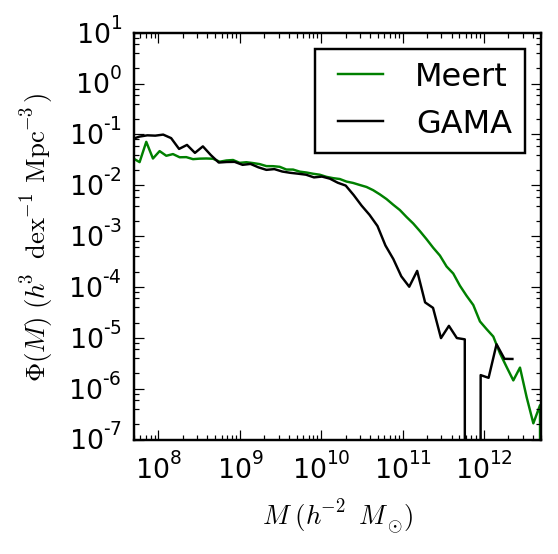

In [4]:
phi_MGama, MGbins = np.histogram(lMstar, weights=vmaxi, bins=nbins)
MGbinc = 0.5 * (MGbins[1:] + MGbins[:-1]); dMGbins = (MGbins[1:]-MGbins[:-1])

phi_MbsGama, ephi_MbsGama = compute_lf_bootstrap(lMstar, vmaxi, MGbins, nbootstrap)
phi_MbsGama = phi_MbsGama  / dMGbins / cosmo.h**3
ephi_MbsGama = ephi_MbsGama  / dMGbins / cosmo.h**3
ephi_MbsGama = np.nan_to_num(ephi_MbsGama)

MGbinc = np.log10(10.**MGbinc*cosmo.h**2)

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e12); plt.ylim(1E-7, 10.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Mbinc, phi_Mbsmeert, c='g', label='Meert')
plt.plot(10.**MGbinc,phi_MbsGama, 'k', label='GAMA')
plt.legend(loc='best')

The GAMA catalogue has a high density at low stellar masses. This can be expected since the GAMA survey probes about 2 magnitudes deeper than SDSS. In comparison, the Meert photometry shows greater and more even distribution of density at higher stellar masses (greater than ~ 10$^{10}$). 
It seems like the Meert catalogue is better suited for stellar masses > 10$^{10.2}$ and GAMA catalogue is more suited for galaxies with stellar masses below that cutoff.

selected 164457  after all cuts...


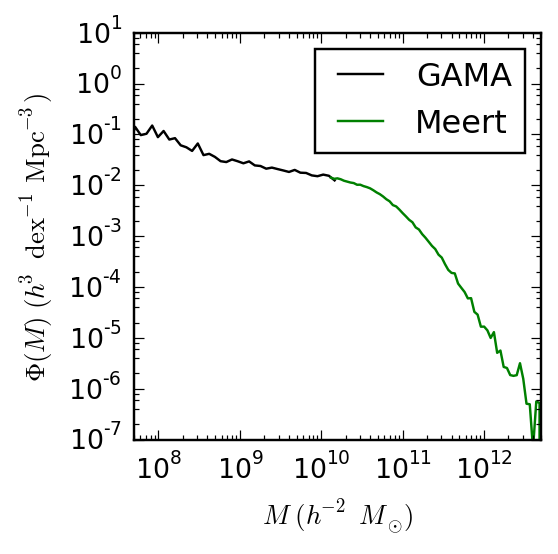

In [5]:
cutoff = np.log10(10**10.2/cosmo.h**2)

newdata = data[data['logmstar'] < (cutoff)]
m_min = 10.5
m_max = 19.
newvmaxi = compute_inverse_Vmax(newdata['PETROMAG_R'], newdata['Z_HELIO'], m_min, m_max)
solid_angle = 0.0487
newvmaxi = 3*newvmaxi / (solid_angle*ccm)
newZ = newdata['metal']/0.0126 # normalize to solar according to Asplund et al. (2004)
newlZ = np.log10(newZ)
newlMstar = newdata['logmstar']
newMstar = np.power(10.,newlMstar)
newclevs = np.linspace(0.2,0.95,4)
newphi_MGama, newMGbins = np.histogram(newlMstar, weights=newvmaxi, bins=nbins)
newMGbinc = 0.5 * (newMGbins[1:] + newMGbins[:-1]); newdMGbins = (newMGbins[1:]-newMGbins[:-1])

newphi_MbsGama, newephi_MbsGama = compute_lf_bootstrap(newlMstar, newvmaxi, newMGbins, nbootstrap)

newphi_MbsGama = newphi_MbsGama  / newdMGbins / cosmo.h**3

newMGbinc = np.log10(10.**newMGbinc*cosmo.h**2)

###for Meert catalogue ###########
#Figuring out what the corresponding cut is in luminosity
newilim = ((-0.306-0.1+1.097*grm + Lmeert > (cutoff-0.1) ))

newsdata = sdata[newilim]; newmdata = mdata[newilim]; newmdatag = mdatag[newilim]; newphot_r = phot_r[newilim] 
newmnpdata = mnpdata[newilim]; newmnpdatag = mnpdatag[newilim]; newgrm = grm[newilim]
newzm = newsdata['z']; newmpetrom = newphot_r['petroMag']; newmmeert = newmdata['m_tot']
newsb50 = sb50[newilim]; newextm = newmnpdata['extinction']; newkcorr = newmnpdata['kcorr']
newpEll = pEll[newilim]; newpS0 = pS0[newilim]; newpSab = pSab[newilim]; newpScd = pScd[newilim]

print "selected", np.size(newzm), " after all cuts..."

newvmaxm = newmnpdata['Vmax']

newd_Lm = cosmo.luminosityDistance(newzm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
newMmeert = newmmeert - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr; 
newMpetrom = newmpetrom - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr;
newMmodel = newphot_r['ModelMag'] - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
m_min = 14.5; m_max = 17.77
newd_Mmax = 1.e-5*np.power(10.,0.2*(m_max-newMpetrom))/(1.+newzm)
newd_Mmin = 1.e-5*np.power(10.,0.2*(m_min-newMpetrom))/(1.+newzm)

# 4.67 is the r-band luminosity in Lsun
newLmeert =  0.4*(4.67-(newMmeert)); newLpetrom = 0.4*(4.67-newMpetrom)
newLmodel = 0.4*(4.67-(newMmodel))
newzsb = (1.+newzm)*np.power(10.,0.1*(23.-newsb50)) - 1.0
newzsb[newzsb>1] = 1.
newd_Msb = cosmo.luminosityDistance(newzsb)/cosmo.h/(1.+newzsb)
newd_Mmax[(newd_Msb<newd_Mmax)] = newd_Msb[(newd_Msb<newd_Mmax)]

newvmaxim = 1.0/(np.power(newd_Mmax,3.0) - np.power(newd_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
newvmaxim = newvmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

#Converting Lr to stellar mass using colour with the Zibetti et al calibration
#lMLrzib = -0.840 + 1.654*xur
newlMLrzib = (-0.840 + 1.654*newgrm)
newlMLrbell = -.306 + 1.097*newgrm - 0.1
newSMmeert = newLmeert+newlMLrbell
newphi_Mmeert, newMbins = np.histogram(newSMmeert, weights=newvmaxim, bins=nbins)
newMbinc = 0.5 * (newMbins[1:] + newMbins[:-1]); newdMbins = (newMbins[1:]-newMbins[:-1])

newphi_Mbsmeert, newephi_Mbsmeert = compute_lf_bootstrap(newSMmeert, newvmaxim, newMbins, nbootstrap)

newphi_Mbsmeert = newphi_Mbsmeert  / newdMbins / cosmo.h**3

newMbinc = np.log10(10.**newMbinc*cosmo.h**2)

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e12); plt.ylim(1E-7, 10.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**newMGbinc,newphi_MbsGama, 'k', label='GAMA')
plt.plot(10.**newMbinc,newphi_Mbsmeert, 'g', label='Meert')
plt.legend(loc='best')

Question #3

In [6]:
import numpy as np

from code.setup import data_home_dir
from code.read_data import read_meert_catalog
from code.read_data import read_alfalfa, read_alfalfa_sdss_crosslist, alfalfa_sdss_crossmatch

# read ALFALFA data and SDSS cross-listing table
print "reading ALFALFA table..."
aalist   = read_alfalfa(data_home_dir()+'a40.datafile1.txt');
print "reading SDSS crosslist table..."
sdsslist = read_alfalfa_sdss_crosslist(data_home_dir()+'a40.datafile3.txt')
# cross-match the catalogs and perform basic cuts
print "cross-matching the catalogs..."
aatf, sdsstf = alfalfa_sdss_crossmatch(aalist, sdsslist)

# read Meert et al. (2015) catalogs for a given photometry model (3=Sersic fits), 
# quality cuts are performed in the routine read_meert_catalog
print "reading Meert et al. catalog..."
data, mdata, mnpdata, phot_r, mdatag, mnpdatag, datamorph = read_meert_catalog(phot_type=3)
#
# match ALFALFA and SDSS catalogs using photoObjID
#
imatch = np.in1d(sdsstf['PhotoObjID'],data['objid'])
imatch2 = np.in1d(data['objid'],sdsstf['PhotoObjID'])
aatfmatch = aatf[imatch]; sdssmatch = sdsstf[imatch]
datamatch = data[imatch2]; photmatch = phot_r[imatch2]
mphotmatch = mdata[imatch2]; morphmatch = datamorph[imatch2]

# extract relevant data
zg = sdssmatch['zsdss']
lMHI = aatfmatch['logMsun']
# to match Martin et al. 2010  HI mass function procedure exactly, select only objects with HIcode = 1
# although Haynes et al. 2011 show that inclusion of HIcode = 2 objects does not bias results significantly
HIcode = aatfmatch['HIcode']
#picking out stuff with HIflux > 1.8Jy km/s
zg = zg[aatfmatch['HIflux'] > 1.8]
lMHI = lMHI[aatfmatch['HIflux']>1.8]

print "HIcode min,max=", np.min(HIcode), np.max(HIcode)

from colossus.cosmology import cosmology
# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')
dlum = cosmo.luminosityDistance(zg)/cosmo.h
rmag = sdssmatch['rmodelmag']
rmag = rmag[aatfmatch['HIflux']>1.8]
# ignore evolution and k-correction here as we are dealing with local galaxies 
Mr = rmag - 5.0*np.log10(dlum/1e-5) 
#Mr = mphotmatch['m_tot'] - 5.0*np.log10(dlum/1e-5) 
Lr = np.power(10.,-0.4*(Mr-4.68)) 

ma_min = 13.0; ma_max = 17.5
# compute 1/Vmax for the galaxies in the sample
# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(ma_max-Mr))/(1.+zg)
d_Mmin = 1.e-5*np.power(10.,0.2*(ma_min-Mr))/(1.+zg)

# inverse Vmax comoving volume to be used as weights in distribution histograms
vmaxig = 3.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# compute mass-to-light ratio using (u-r) color and Bell et al. (2003) calibrations
lMLr = -0.223 + 0.299*sdssmatch['uminusr']
lMLr = lMLr[aatfmatch['HIflux']>1.8]
lSMAl = lMLr + np.log10(Lr)
# 1.4 factor corrects atomic hydrogen mass for the Helium
MHI = 1.4*np.power(10.,lMHI)
print lSMAl

reading ALFALFA table...
reading SDSS crosslist table...
cross-matching the catalogs...
reading Meert et al. catalog...
670722 galaxies in Meert et al. sample initially
HIcode min,max= 1 2
[ 10.07785319  10.1122138    9.62504629 ...,  10.39786664  10.35655214
  10.45748235]


In [7]:
#weighing by redshift densities
density, z_bins = np.histogram(zg, bins=80)
avg_density = np.mean(density)
density_weight = density/avg_density
mod_vmaxig = np.zeros((len(vmaxig)))
for i in np.arange(len(zg)):
    bin_number = (np.where(z_bins >= zg[i])[0]-1)[0]
    mod_vmaxig[i] = vmaxig[i]/density_weight[bin_number]

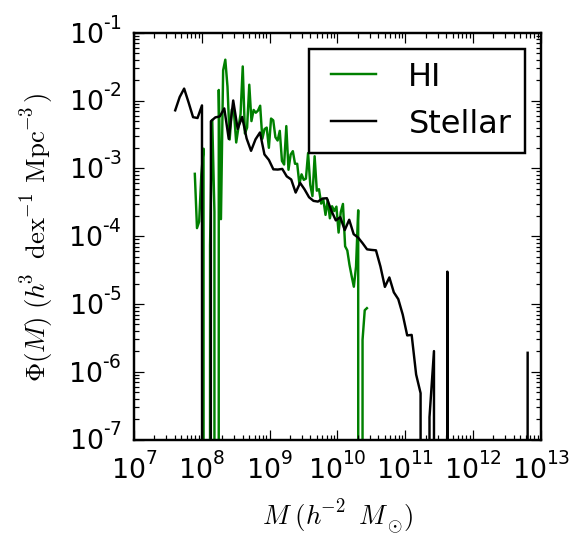

In [8]:
phi_MAl, MAlbins = np.histogram(lMHI, weights=mod_vmaxig, bins=nbins)
MAlbinc = 0.5 * (MAlbins[1:] + MAlbins[:-1]); dMAlbins = (MAlbins[1:]-MAlbins[:-1])

phi_MbsAl, ephi_MbsAl = compute_lf_bootstrap(lMHI, mod_vmaxig, MAlbins, nbootstrap)
phi_MbsAl = phi_MbsAl  / dMAlbins / cosmo.h**3
ephi_MbsAl = ephi_MbsAl  / dMAlbins / cosmo.h**3
ephi_MbsAl = np.nan_to_num(ephi_MbsAl)

MAlbinc = np.log10(10.**MAlbinc*cosmo.h**2)

phi_MAlSt, MAlStbins = np.histogram(lSMAl, weights=mod_vmaxig, bins=nbins)
MAlStbinc = 0.5 * (MAlStbins[1:] + MAlStbins[:-1]); dMAlStbins = (MAlStbins[1:]-MAlStbins[:-1])

phi_MbsAlSt, ephi_MbsAlSt = compute_lf_bootstrap(lSMAl, mod_vmaxig, MAlStbins, nbootstrap)

phi_MbsAlSt = phi_MbsAlSt  / dMAlStbins / cosmo.h**3
ephi_MbsAlSt = ephi_MbsAlSt  / dMAlStbins / cosmo.h**3
ephi_MbsAlSt = np.nan_to_num(ephi_MbsAlSt)

MAlStbinc = np.log10(10.**MAlStbinc*cosmo.h**2)

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
#plt.xlim(5.e7, 5e12); plt.ylim(1E-7, 10.)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**MAlbinc, phi_MbsAl, c='g', label='HI')
plt.plot(10.**MAlStbinc, phi_MbsAlSt, c='k', label='Stellar')
plt.legend(loc='best')

In this code, I've limited the ALFALFA and SDSS crosslisted data with a HIflux cut of > 1.8 Jy km/s. In addition, I introduced a new correction by adding the density weight (which comes from binning the redshifts of galaxies in the sample). Both the stellar mass function and the HI Mass funcction has a dip near $10^8$. I'm not sure why this is and I suspect there is something wrong with my code in this regard. The HI MF seems to be less smooth than the stellar MF. Although the shapes look similar, the HI MF seems to have a higher density over most of the mass range. However, there does appear a slight drop in density for masses below $10^8$. In comparison to Martin 2010, I can see that my HI MF does not seem complete, since it does not provide information for HI masses $> 10^10$ and $< 10^8$. In addition, my plot has an overall smaller density compared to that of the paper, although they still share similar shapes. 

Question #4

670722 galaxies in Meert et al. sample initially
selected 24459  after all cuts...
best fit Schechter parameters: phi_*=8.28e-04 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=9.73, alpha=2.55
670722 galaxies in Meert et al. sample initially
selected 239462  after all cuts...
best fit Schechter parameters for the WHOLE survey: phi_*=9.66e-03 [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=10.25, alpha=-0.16


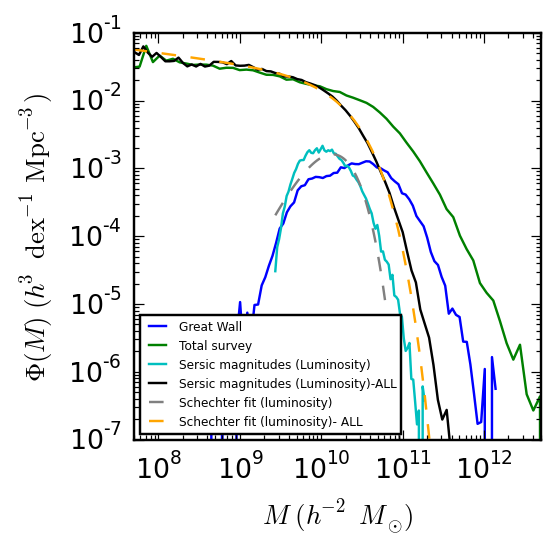

In [14]:
%matplotlib inline
import numpy as np
from colossus.cosmology import cosmology

# set cosmology to the best values from 9-year WMAP data
cosmo = cosmology.setCosmology('WMAP9')

def compute_lf_bootstrap (lum, vmi, lbins, nbootstraps = 20):
    """
    computes LF and bootstrap errors given a vector of luminosities
    lum, 1/Vmax values (vmi), and specified luminosity bins (lbins)
    """
    l_dist = np.zeros((nbootstraps, len(lbins) - 1))

    for i in range(nbootstraps):
        ind = np.random.randint(0, len(lum), len(lum))
        l_dist[i], ldbins = np.histogram(lum[ind], weights=vmi[ind], bins=lbins)

    return (l_dist.mean(0), l_dist.std(0, ddof=1))


# to save space the routine to read the catalog is now in code/read_data
from code.read_data import read_meert_catalog
# input phot_type selects photometry model fit:  1=best fit, 2=deVaucouleurs, 3=Sersic, 4=DeVExp, 5=SerExp
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)
vmaxm = mnpdata['Vmax'];

grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']


# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.06; z_max = 0.12
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])

ilim = (vmaxm>0) & (mrm > m_min) & (mrm < m_max) & (sdata['dec'] > 10) &(sdata['dec'] < 20) & (sdata['z'] > z_min) &(sdata['z'] < z_max) & (sb50 > 0.) & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2)

sdata = sdata[ilim]; mdata = mdata[ilim]; phot_r = phot_r[ilim] 
mnpdata = mnpdata[ilim]; grm = grm[ilim]
zm = sdata['z']; mpetrom = phot_r['petroMag']; mmeert = mdata['m_tot']
sb50 = sb50[ilim]; extm = mnpdata['extinction']; kcorr = mnpdata['kcorr']


print "selected", np.size(zm), " after all cuts..."

vmaxm = mnpdata['Vmax']

d_Lm = cosmo.luminosityDistance(zm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
Mmeert = mmeert - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr; 
Mpetrom = mpetrom - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;
Mmodel = phot_r['ModelMag'] - 5.0*np.log10(d_Lm/1e-5) - extm + 1.3*zm - kcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
d_Mmax = 1.e-5*np.power(10.,0.2*(m_max-Mpetrom))/(1.+zm)
d_Mmin = 1.e-5*np.power(10.,0.2*(m_min-Mpetrom))/(1.+zm)

# 4.67 is the r-band luminosity in Lsun
Lmeert =  0.4*(4.67-(Mmeert)); Lpetrom = 0.4*(4.67-Mpetrom)
Lmodel = 0.4*(4.67-(Mmodel))
zsb = (1.+zm)*np.power(10.,0.1*(23.-sb50)) - 1.0
zsb[zsb>1] = 1.
d_Msb = cosmo.luminosityDistance(zsb)/cosmo.h/(1.+zsb)
d_Mmax[(d_Msb<d_Mmax)] = d_Msb[(d_Msb<d_Mmax)]

vmaxim = 1.0/(np.power(d_Mmax,3.0) - np.power(d_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
vmaxim = vmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
phi_Lmeert, Lbins = np.histogram(Lmeert, weights=vmaxim, bins=nbins)
Lbinc = 0.5 * (Lbins[1:] + Lbins[:-1]); dLbins = (Lbins[1:]-Lbins[:-1])

phi_Lbsmeert, ephi_Lbsmeert = compute_lf_bootstrap(Lmeert, vmaxim, Lbins, nbootstrap)

phi_Lbsmeert = phi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = ephi_Lbsmeert  / dLbins / cosmo.h**3
ephi_Lbsmeert = np.nan_to_num(ephi_Lbsmeert)

Lbinc = np.log10(10.**Lbinc*cosmo.h**2)

from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
fitsel = (phi_Lbsmeert>1.e-7) & (Lbinc>8.) 
Lbfit = Lbinc[fitsel]; phi_fit = phi_Lbsmeert[fitsel]; ephi_fit = ephi_Lbsmeert[fitsel]

popt, pcov = curve_fit(lf_schechter, Lbfit, phi_fit, sigma=ephi_fit, p0 =p0, check_finite=True) 
print "best fit Schechter parameters: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt[0],popt[1],popt[2])

#Converting Lr to stellar mass using colour with the Zibetti et al calibration
#lMLrzib = -0.840 + 1.654*xur
lMLrzib = (-0.840 + 1.654*grm)
lMLrbell = -.306 + 1.097*grm - 0.1
SMmeert = Lmeert+lMLrbell
phi_Mmeert, Mbins = np.histogram(SMmeert, weights=vmaxim, bins=nbins)
Mbinc = 0.5 * (Mbins[1:] + Mbins[:-1]); dMbins = (Mbins[1:]-Mbins[:-1])

phi_Mbsmeert, ephi_Mbsmeert = compute_lf_bootstrap(SMmeert, vmaxim, Mbins, nbootstrap)

phi_Mbsmeert = phi_Mbsmeert  / dMbins / cosmo.h**3
ephi_Mbsmeert = ephi_Mbsmeert  / dMbins / cosmo.h**3
ephi_Mbsmeert = np.nan_to_num(ephi_Mbsmeert)

Mbinc = np.log10(10.**Mbinc*cosmo.h**2)
del grm, sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph, z_min, z_max, extm, size,mrm

###For full survey
###for FULL Meert catalogue ###########
#Figuring out what the corresponding cut is in luminosity
sdata, mdata, mnpdata, phot_r, mdatag, mnpdatag, morph = read_meert_catalog(phot_type=3)
grm = mdatag['m_tot'] - mdata['m_tot'] - mnpdatag['extinction'] + mnpdata['extinction']

# define some limiting parameters for the sample and make the corresponding cuts
z_min = 0.005; z_max = 1.
m_min = 14.5; m_max = 17.77

# impose sample limits
size = phot_r['petroR50']
# surface brightess = -2.5log10(f/(pi*r^2))+ const
# term - 2.5*np.log10(0.5) below is to account that we are using the *half* light radius
extm = mnpdata['extinction']
mrm = phot_r['petroMag'] - extm
sb50 = mrm - 2.5*np.log10(0.5) + 2.5*np.log10(np.pi*(size)**2) #+ 10.*np.log10(1.+data['z'])
pE = morph['probaE']; pEll = morph['probaEll']; pS0  = morph['probaS0']; pSab = morph['probaSab']; pScd = morph['probaScd']; 
newilim = ((mrm > m_min) & (mrm < m_max) & (sdata['z'] > z_min) & (sb50 > 0.) 
        & (sb50 <= 23.) & (grm>-0.5) & (grm<2.2) & (pEll>=0) & (pS0>=0) & (pSab>=0) & (pScd>=0))

newsdata = sdata[newilim]; newmdata = mdata[newilim]; newmdatag = mdatag[newilim]; newphot_r = phot_r[newilim] 
newmnpdata = mnpdata[newilim]; newmnpdatag = mnpdatag[newilim]; newgrm = grm[newilim]
newzm = newsdata['z']; newmpetrom = newphot_r['petroMag']; newmmeert = newmdata['m_tot']
newsb50 = sb50[newilim]; newextm = newmnpdata['extinction']; newkcorr = newmnpdata['kcorr']
newpEll = pEll[newilim]; newpS0 = pS0[newilim]; newpSab = pSab[newilim]; newpScd = pScd[newilim]

print "selected", np.size(newzm), " after all cuts..."

newvmaxm = newmnpdata['Vmax']

newd_Lm = cosmo.luminosityDistance(newzm)/cosmo.h

# compute k-correction using polynomial approximations of Chilingarian et al. 2010
# see http://kcor.sai.msu.ru/getthecode/
#from code.calc_kcor import calc_kcor 
#ihz = [z>0.9]; zk = z; zk[ihz] = 0.9
#kcorr = calc_kcor('r', zk, 'g - r', grm)

# absolute magnitude in the r-band corrected for extinction
newMmeert = newmmeert - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr; 
newMpetrom = newmpetrom - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr;
newMmodel = newphot_r['ModelMag'] - 5.0*np.log10(newd_Lm/1e-5) - newextm + 1.3*newzm - newkcorr;

# the sample magnitude limit is defined using Petrosian magnitude, so this is what we need to use to compute Vmax
# we need to compute at what distance this galaxy would have limiting magnitude mlim, 
# then compute Vmax using this distance, assuming flat cosmology (not a big deal at these low z): Vmax=d_M^3(z); d_M=d_L/(1+z) 
m_min = 14.5; m_max = 17.77
newd_Mmax = 1.e-5*np.power(10.,0.2*(m_max-newMpetrom))/(1.+newzm)
newd_Mmin = 1.e-5*np.power(10.,0.2*(m_min-newMpetrom))/(1.+newzm)

# 4.67 is the r-band luminosity in Lsun
newLmeert =  0.4*(4.67-(newMmeert)); newLpetrom = 0.4*(4.67-newMpetrom)
newLmodel = 0.4*(4.67-(newMmodel))
newzsb = (1.+newzm)*np.power(10.,0.1*(23.-newsb50)) - 1.0
newzsb[newzsb>1] = 1.
newd_Msb = cosmo.luminosityDistance(newzsb)/cosmo.h/(1.+newzsb)
newd_Mmax[(newd_Msb<newd_Mmax)] = newd_Msb[(newd_Msb<newd_Mmax)]

newvmaxim = 1.0/(np.power(newd_Mmax,3.0) - np.power(newd_Mmin,3.0))

# 0.93 - spectroscopic completeness correction - see Bernardi et al. 2010
# magnitude dependence approximates results of Montero-Dorta & Prada 2009
ccm = 0.93#*(mpetrom/17)**(0.5)

solid_anglem = 4.*np.pi/3*0.195
#solid_anglem = 4681.*(np.pi/180)**2
newvmaxim = newvmaxim / (solid_anglem*ccm)
#vmaxim = 1.0/vmaxm/ccm

#Converting Lr to stellar mass using colour with the Zibetti et al calibration
#lMLrzib = -0.840 + 1.654*xur
newlMLrzib = (-0.840 + 1.654*newgrm)
newlMLrbell = -.306 + 1.097*newgrm - 0.1
newSMmeert = newLmeert+newlMLrbell
newphi_Mmeert, newMbins = np.histogram(newSMmeert, weights=newvmaxim, bins=nbins)
newMbinc = 0.5 * (newMbins[1:] + newMbins[:-1]); newdMbins = (newMbins[1:]-newMbins[:-1])

newphi_Mbsmeert, newephi_Mbsmeert = compute_lf_bootstrap(newSMmeert, newvmaxim, newMbins, nbootstrap)

newphi_Mbsmeert = newphi_Mbsmeert  / newdMbins / cosmo.h**3

newMbinc = np.log10(10.**newMbinc*cosmo.h**2)

# compute luminosity function for all galaxies and bootstrap errors
nbootstrap = 10; nbins = 80
newphi_Lmeert, newLbins = np.histogram(newLmeert, weights=newvmaxim, bins=nbins)
newLbinc = 0.5 * (newLbins[1:] + newLbins[:-1]); newdLbins = (newLbins[1:]-newLbins[:-1])

newphi_Lbsmeert, newephi_Lbsmeert = compute_lf_bootstrap(newLmeert, newvmaxim, newLbins, nbootstrap)

newphi_Lbsmeert = newphi_Lbsmeert  / newdLbins / cosmo.h**3
newephi_Lbsmeert = newephi_Lbsmeert  / newdLbins / cosmo.h**3
newephi_Lbsmeert = np.nan_to_num(newephi_Lbsmeert)

newLbinc = np.log10(10.**newLbinc*cosmo.h**2)

from scipy.optimize import curve_fit

def lf_schechter(L, phis, Lstar, alpha):
    mus = np.power(10,L)/np.power(10,Lstar)
    #print "phis, Lstar, alpha", phis, Lstar, alpha
    return np.log(10.)*phis*mus**(alpha)*np.exp(-mus)

p0 = [2.5e-3, 10.5, -0.3]
newfitsel = (newphi_Lbsmeert>1.e-7) & (newLbinc>8.) 
newLbfit = newLbinc[newfitsel]; newphi_fit = newphi_Lbsmeert[newfitsel]; newephi_fit = newephi_Lbsmeert[newfitsel]

popt1, pcov1 = curve_fit(lf_schechter, newLbfit, newphi_fit, sigma=newephi_fit, p0 =p0, check_finite=True) 
print "best fit Schechter parameters for the WHOLE survey: phi_*=%.2e [h^3 Mpc^-3 dex^-1], log10[L*/h^-2 Lsun]=%.2f, alpha=%.2f"%(popt1[0],popt1[1],popt1[2])

# plot LF
#
import matplotlib.pyplot as plt

plt.rc("savefig",dpi=175)
plt.rc('text', usetex=False)
plt.rc('font',size=9)
plt.rc('xtick.major',pad=5); plt.rc('xtick.minor',pad=5)
plt.rc('ytick.major',pad=5); plt.rc('ytick.minor',pad=5)

fig = plt.figure(figsize=(3, 3))

plt.xlabel(r'$M\ (h^{-2}\, M_{\odot})$'); plt.ylabel(r'$\Phi(M)\ (h^3\ \mathrm{dex^{-1}\ Mpc^{-3}})$')
plt.xlim(5.e7, 5e12); plt.ylim(1E-7, 0.1)
plt.xscale('log'); plt.yscale('log')
plt.rc('font',size=11)

plt.plot(10.**Mbinc, phi_Mbsmeert, c='b', label='Great Wall')
plt.plot(10.**newMbinc, newphi_Mbsmeert, c='g', label = 'Total survey')
plt.plot(10.**Lbinc, phi_Lbsmeert, c='c', label='Sersic magnitudes (Luminosity)')
plt.plot(10.**newLbinc, newphi_Lbsmeert, c='k', label='Sersic magnitudes (Luminosity)-ALL')

#plt.errorbar(10.**Lbinc, phi_Lbsmeert, yerr=ephi_Lbsmeert, c='g')
# plot Schechter fit
Lsexp = int(popt[1]); Lsnum = popt[1] - Lsexp
plt.plot(10.**Lbinc, lf_schechter(Lbinc, popt[0], popt[1], popt[2]), '--', c='gray', label='Schechter fit (luminosity)')
plt.plot(10.**newLbinc, lf_schechter(newLbinc, popt1[0], popt1[1], popt1[2]), '--', c='orange', label='Schechter fit (luminosity)- ALL')
plt.legend(prop={'size':5}, loc='best')

The best Schechter fit parameters for the luminosity function derived based on the sample was printed above. There are some differences in $\phi_*$ and $L_*$ but the biggest difference is in $\alpha$.